# Texture Synthesis Using Convolutional Neural Networks

I tried to implement this paper as faithfully as I could and I think for the most part I succeeded. One issue though, in the paper they "rescaled the weights in the network such that the mean activation of each filter over images and positions is equal to one". I couldn't work out how to do this exactly so I just skipped it. Just something to keep

In [120]:
import torch
import os
import numpy as np
import scipy.ndimage
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim, nn
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from PIL import Image

from matplotlib import pyplot as plt

## Setting up the model

First, we download a pre-trained vgg19 model (as recommended in the paper).

In [121]:
vgg19 = models.vgg19(pretrained=True)

Load the model onto your GPU (if you have one) and "freeze" it, preventing any additional gradient updates from occurring to the already trained model. 

**Note:** I'm freezing each set of parameters individually *after* loading the model into my GPU. This is because the process of loading into the GPU destroys the old parameter tensors and creates new ones on the GPU (so freezing beforehand would have no effect).

In [122]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg19 = vgg19.to(device)
for param in vgg19.features.parameters(): # stop training the net
    param.requires_grad = False

Confirm that the network really is loaded onto the GPU.

In [123]:
next(vgg19.parameters()).is_cuda # Should be `True` if you have a GPU

True

### Normalization

vgg19 expects all inputs to be normalized according to the imagenet input means and standard deviations. Un-normalized inputs will still work, but the results are less visually appealing. To help us normalize inputs we will create a custom `Normalization` layer. Everything we pass to our vgg model will go through this layer first. 

In [124]:
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
    
normalization_layer = Normalization(normalization_mean, normalization_std).to(device)

Next we make a new network, using the first 38 layers from our pretrained vgg network. For our purposes we won't need the rest, and removing the fully connected layers near the end means we can work with inputs of varying sizes.  

The first layer in our new network will be our custom normalization layer.

**Note:** `some_model.children()` returns an iterator containing all of the model's layers. Common practice is to turn this into a list in order to interact with it. With vgg19 what you'll actually get is a list containing two lists. The first of these contains all the layers we need.

In [125]:
useful_layers = list(list(vgg19.children())[0])
useful_layers.insert(0, normalization_layer)

vgg = nn.Sequential(*useful_layers)
print(len(list(vgg.children()))) # should be 14
list(vgg.children())

38


[Normalization(),
 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),

Optionally, we can also replace all the max pool layers in our vgg network with average pool layers as suggested in the paper. Personally I found that this made gradient updates a bit trickier, but it did give nicer results once I got it working.

In [127]:
vgg_layers = list(vgg.children())

for i in range(len(vgg_layers)):
    if (vgg_layers[i].__class__.__name__ == "MaxPool2d"):
        vgg_layers[i] = nn.AvgPool2d(2)

## Perpairing the example texture

The pre-trained networks from torchvision.models need to be passed inputs in a certain format, so we're going to add a transform to apply those transformations to all the image's we're dealing with. We also define a helper function `image_loader` which takes a relative image path, loads the image into a tensor, applies the relevant transformations and returns it.

`show_image` makes it easier to view images we load using `image_loader`. Pytorch doesn't seem to have any good method for visualizing tensors, so we convert the tensor to a numpy array, transpose it and then plot that using matplotlib.

**Note:** `unsqueeze()` is a pytorch function that adds extra dimensions to tensors. We're using it here because vgg19 only takes mini-batches of images, and we're working with a single image. We use `.unsqueeze()` to add the extra dimension to our image tensor and trick vgg into thinking it's dealing with a small minibatch of images. 

**Note 2:** For classification vgg19 expects input images to be normalized according to imagenet mean values. The commented out line below applies this transform. We're not doing classification though and *should not* add it here. It would cause our sample textures to be optimized to look like the *normalized* version of the example texture (i.e. off color and weird). See `data/samples/stones-normalized` for what happened to me. We can also ignore the usual size constraint of 224x224 since convolutional layers are size-agonstic and we already removed all the fully connected layers.

In [128]:
transform = transforms.Compose([
        transforms.RandomResizedCrop(400),
        transforms.ToTensor(),
    ])

def image_loader(image_path):
    """load image, returns cuda tensor"""
    image = Image.open(image_path)
    image = transform(image).float()
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

def show_image(image_tensor):
    np_image = image_tensor.squeeze().cpu().detach().numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

Now we actually load in the image (and also plot it out).

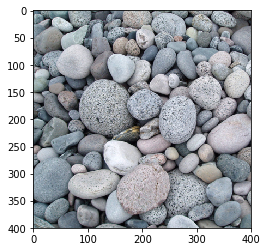

In [129]:
img_path = "data/examples/"
img_name = "stones.jpg" # we use this variable later
full_path = img_path + img_name

example_texture = image_loader(full_path)
show_image(example_texture)

## Extracting Layer activations

The guys in the paper defined the texture profile of the example texture as the **gram matrices** of the feature maps of some of the convolutional or pooling layers in vgg19 after feeding in that example texture. In order to get at these feature maps we're going to use pytorch's hook feature. 

### Hooks

Basically hooks are classes with `.hook_fn`, `.__init__` and `close` methods. `__init__` should take a layer from a module and register the hook's `hook_fn` method on that layer. Whenever the layer is run from then on, `hook_fn` for that hook instance will be called, being passed in the model holding the layer, the layer's input and the layer's output in that order. Let's ignore `close()` for now.

In this case all we want to do is save the output of each layer, so we create a simple `hook_fn` that just saves the layer's output tensor on the hook instance for later use when called.

In [130]:
class SaveFeatures():
    features=None
    def __init__(self, layer): 
        self.hook = layer.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = output
    def close(self): 
        self.hook.remove()

The guys from the paper found that we don't need input from every single layer. One from each **scale** of the network (a new scale occurs when the input is down-sampled, i.e. pooling layers) seems to be enough. We register a hook instance on a convolutional or pooling layer from each scale (there are 5 scales in vgg).

In [133]:
layer_feature_maps = []

all_layers = list(vgg.children())

for index in [3, 6, 19, 26, 37]: # remember we're offsetting for the normalization layer
    layer = all_layers[index]
    layer_name = layer.__class__.__name__
    if layer_name == "Conv2d"  or layer_name == 'MaxPool2d' or layer_name == 'AvgPool2d':
        layer_feature_maps.append(SaveFeatures(layer))

print(len(layer_feature_maps)) # should be 5

5


Now we just run our network with all those conv and pooling layers already hooked, and the `.features` attributes of all our hook instances will automatically be populated with the feature maps of all those layers (as per `hook_fn`). 

In [134]:
print(type(layer_feature_maps[2].features) == type(None)) # should be True the first time you run this
vgg(example_texture)
print(layer_feature_maps[2].features[0][0][0]) # should be a tensor with random numbers in

True
tensor([12.2191,  6.4026,  0.1131,  1.1696,  0.0000, 30.2804, 15.1613,  0.0000,
         2.8757,  7.5404,  0.0000,  0.0000,  3.2243, 11.1741,  6.7454, 11.0179,
        17.5300,  0.9348, 11.2988,  7.0645,  9.0327,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  8.2762, 11.5030,  3.9431,  9.1506, 17.8645,  9.0895,
         7.1968,  5.8622,  0.0000,  4.2305,  9.9089,  0.0000,  1.0521,  4.4595,
         0.0000,  0.0000,  0.0000,  0.0000, 14.8578, 19.4318,  3.0501,  9.0552,
         5.9435, 11.4239], device='cuda:0')


So now we have all the feature maps we need, but for texture synthesis we want to make a gram matrix for each layer's feature maps. Let's make a helper function that takes all the feature maps from a layer and returns a gram matrix. I copy-pasted this myself from somewhere random.

In [135]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d) # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Now we have this function, let's use it to create a list of gram matrices, one for each layer we're interested in. This list represents all the summary statistics we will need from the example input. The values in this tensor will probably be tiny, or actually 0.

In [136]:
example_stats = [gram_matrix(layer.features) for layer in layer_feature_maps]
print(len(example_stats)) # should be 5
print(example_stats[0]) # should be a tensor. It will probably have very small values.

5
tensor([[0.0136, 0.0000, 0.0041,  ..., 0.0050, 0.0024, 0.0049],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0041, 0.0000, 0.0060,  ..., 0.0038, 0.0015, 0.0045],
        ...,
        [0.0050, 0.0000, 0.0038,  ..., 0.0092, 0.0015, 0.0057],
        [0.0024, 0.0000, 0.0015,  ..., 0.0015, 0.0051, 0.0041],
        [0.0049, 0.0000, 0.0045,  ..., 0.0057, 0.0041, 0.0378]],
       device='cuda:0')


## Computing Loss

Next we need a way of generating a loss from the example summary statistics (above), and some sample summary statistics (which we will eventually generate by passing the sample texture through our vgg network in exactly the same way). The paper recommends calculating the **mean squared error** loss between the two sets of gram matrices.

I had a lot of trouble with this. The losses were always tiny (probably because, as above, the gram matrices I calculated from the feature maps tended to hold super small values), and often resulted in outright 0 gradients. The hacky-as-balls solution I came up with was to literally just scale the loss by some factor before returning. Gross I know.

The paper also recommends using LBFGS to perform gradient updates. `torch.optim` provides a convenience [method](https://pytorch.org/docs/stable/optim.html) for this which you should probably look up. The main takeaway is: if you're using `torch.optim.LBFGS()` as your optimizer, you can't just call `optimizer.step()` like normal. Instead, you need to pass in a special `closure()` function that calculates and returns your loss. Because we can't pass any arguments to the `closure()` function directly, we're going to create a class (`GradientStepper`) around this `closure()` function and use attribute variables on that class as parameters to our `closure()`. 

We'll also add our loss function to this class for conveniance.

In [137]:
class GradientStepper():
    def __init__(self, optimizer, model, sample_texture, layer_feature_maps, scale):
        self.optimizer = optimizer
        self.sample_texture = sample_texture
        self.model = model
        self.layer_feature_maps = layer_feature_maps
        self.scale = scale

    def loss_fn(self, stats, target_stats):
        loss = 0
        for i in range(len(target_stats)):
            loss += torch.mean((stats[i] - target_stats[i]).pow(2)) # mean squared error

        print("scale: {}".format(self.scale))
        return loss * self.scale
    
    def closure(self):
        self.optimizer.zero_grad() # Please read up on this if you don't know what it does. 

        self.model(self.sample_texture)
        sample_stats = [gram_matrix(layer.features) for layer in self.layer_feature_maps]

        loss = self.loss_fn(sample_stats, example_stats)
        loss.backward()

        print("loss: {}".format(loss))

        return loss


## Create the Sample Texture

Nearly there. Now we need to create a random image that will eventually become out sample texture. We're going to pass this texture through our vgg network and keep performing gradient descent on it against the above loss function until its summary statistics more or less match the example texture.

We use numpy to create the random image here because numpy is generally better at operating on matrices. In particular we want to smoothen the image because real life images have a natural smoothness to them.


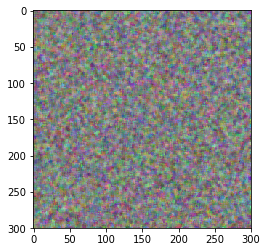

In [138]:
def random_image(blur=6, size=300):
    # create random noise numpy array
    np_sample = np.random.rand(size, size, 3)

    # smooth it out (try commenting out this line and see the difference)
    np_sample = scipy.ndimage.filters.median_filter(np_sample, [blur, blur,1]) 

    # finally convert to a tensor with autograd enabled (since we're 
    # going to be performing gradient updates on this image)
    sample = torch.from_numpy(np_sample).float().permute(2, 0, 1).unsqueeze(0).to(device) 
    sample.requires_grad = True
    
    return sample

show_image(random_image(5))

## Generate the Sample Texture

And here we are. Basically all we do now is perform an arbitrary number of gradient updates on the random sample texture. Once that's done it should look a bit like the example texture (hopefully). To make this clean and reusable, we're going to pack this process into a class called `Synthesizer`, which will take in a bunch of hyperparameters and also save the generated textures as `.jpg`'s for viewing later.

First though, we're going to define some conveniance functions.

In [139]:
def make_optimizer(name, sample_texture, lr):
    if name == "LBFGS":
        return optim.LBFGS([sample_texture], lr=0.1)
    if name == "Adam":
        return optim.Adam([sample_texture], lr=0.1) 
    
    raise ValueError('Name was not a valid optimizer identifier')

### Viewing Images

Rather than displaying the generated images here in the notebook I'm saving them to directories in this workspace. This way we can examine them at them at our leisure later. In particular I want to save a bunch of images throughout the generation process so I can observe how it's going. I'm going to give each image an "identifier", which is basically just a string representation of the hyperparameters used to generate it.


In [140]:
def identifier(params):
    id = ""
    for key in params:
        if key not in ["layer_feature_maps", "model", "iterations", "id"]:
            if key == "name":
                id += params[key].replace(".jpg", "") + "-"
            else:
                id += "{}{}-".format(key, params[key])
        
    return id[:-1]

### Synthesizer

The only important method is `synthesize`, the rest of it is just there to save the sample textures to the right directories. Basically this method takes a bunch of hyperparameters, generates a (quasi) random image, and performs gradient updates on it for a given number of iterations using the `GradientStepper` class we defined earlier.

In [141]:
class Synthesizer():
    
    sample_directory = "data/samples"
    
    def __init__(self, params):
        self.save_mode = params["save_mode"]
               
    def prepair_save_directory(self, params):
        self.identifier = params["id"]
        
        if self.save_mode == "final":
            self.dir_path = Synthesizer.sample_directory + "/lol"
            self.save_at = params["iterations"]
            
        elif self.save_mode == "throughout":
            self.dir_path = Synthesizer.sample_directory + "/" + self.identifier
            self.save_at = 1
        
        if not os.path.exists(self.dir_path):
            os.makedirs(self.dir_path)
    
    def save_path(self):
        if self.save_mode == "final":
            file_name = self.identifier
        elif self.save_mode == "throughout":
            file_name = self.save_at
        
        return "{}/{}.jpg".format(self.dir_path , file_name)
    
    def synthesize(self, params):
        sample_texture = random_image(params["blur"], params["size"])
        optimizer = make_optimizer(params["optimizer"], sample_texture, params["lr"]) 
        stepper = GradientStepper(optimizer, params["model"], sample_texture, params["layer_feature_maps"], params["scale"])
        
        self.prepair_save_directory(params)

        for i in range (params["iterations"]):
            if sample_texture.grad is not None:
                print(sample_texture.grad[0][0][0][:4])

            optimizer.step(stepper.closure)

            # occationally save an image so see how generation is going
            if (i + 1) == self.save_at:
                save_image(sample_texture, self.save_path())
                self.save_at *= 2

                if params["scale_decay"] > 0:
                    stepper.scale -= (stepper.scale / params["scale_decay"])
        
        return sample_texture

### Execution

Feel free to fiddle around with hyperparameters here, but I did a fair bit of fiddling myself, and to be honest  the only thing that seemed to make any real difference was the scale, which just needed to remain > 10,000.

In [142]:
params = {
    "name": img_name,
    "size": 300,
    "layers": 5,
    "iterations": 128,
    "blur": 5,
    "scale_decay": 0, # 0 means no scale decay
    "scale": 100000,
    "model": vgg,
    "layer_feature_maps": layer_feature_maps,
    "optimizer": "LBFGS",
    "lr": 0.1,
}

meta_params = {
    "save_mode": "final" 
    # determine whether to save just the final image, or save at intervals while generating
}

syn = Synthesizer(meta_params)

for s in [100000]:
    for sd in [0]:
        for blur in [5, 4, 3]:
            params["scale_decay"] = sd
            params["scale"] = s
            params["blur"] = blur
            params["id"] = identifier(params) 

            print(params["id"])

            syn.synthesize(params)

stones-layers5-blur5-scale_decay0-scale100000-optimizerLBFGS-lr0.1
scale: 100000
loss: 424.92108154296875
scale: 100000
loss: 424.9132385253906
scale: 100000
loss: 359.2779235839844
scale: 100000
loss: 330.0804748535156
scale: 100000
loss: 315.3858337402344
scale: 100000
loss: 299.0571594238281
scale: 100000
loss: 284.2503662109375
scale: 100000
loss: 270.68878173828125
scale: 100000
loss: 257.5620422363281
scale: 100000
loss: 245.70599365234375
scale: 100000
loss: 233.97921752929688
scale: 100000
loss: 222.9204559326172
scale: 100000
loss: 212.12319946289062
scale: 100000
loss: 201.57965087890625
scale: 100000
loss: 191.228271484375
scale: 100000
loss: 181.78085327148438
scale: 100000
loss: 172.66668701171875
scale: 100000
loss: 164.48524475097656
scale: 100000
loss: 156.66873168945312
scale: 100000
loss: 148.776123046875
tensor([-0.0549, -0.0647, -0.0350, -0.0616], device='cuda:0')
scale: 100000
loss: 141.82749938964844
scale: 100000
loss: 134.90045166015625
scale: 100000
loss: 128.7

scale: 100000
loss: 1.3649122714996338
tensor([0.0000, 0.0001, 0.0001, 0.0002], device='cuda:0')
scale: 100000
loss: 1.3518601655960083
scale: 100000
loss: 1.3378088474273682
scale: 100000
loss: 1.3259633779525757
scale: 100000
loss: 1.3134201765060425
scale: 100000
loss: 1.3002612590789795
scale: 100000
loss: 1.286344289779663
scale: 100000
loss: 1.2725622653961182
scale: 100000
loss: 1.2596006393432617
scale: 100000
loss: 1.2463552951812744
scale: 100000
loss: 1.2339445352554321
scale: 100000
loss: 1.2216678857803345
scale: 100000
loss: 1.2109012603759766
scale: 100000
loss: 1.1994282007217407
scale: 100000
loss: 1.1884042024612427
scale: 100000
loss: 1.1774873733520508
scale: 100000
loss: 1.1666682958602905
scale: 100000
loss: 1.154471516609192
scale: 100000
loss: 1.1444172859191895
scale: 100000
loss: 1.1330660581588745
scale: 100000
loss: 1.1208709478378296
tensor([0.0000, 0.0001, 0.0001, 0.0002], device='cuda:0')
scale: 100000
loss: 1.1100635528564453
scale: 100000
loss: 1.099309

scale: 100000
loss: 0.3843112289905548
scale: 100000
loss: 0.3829243779182434
scale: 100000
loss: 0.381667822599411
scale: 100000
loss: 0.3803795278072357
scale: 100000
loss: 0.379071980714798
tensor([-0.0000, -0.0001, -0.0000,  0.0000], device='cuda:0')
scale: 100000
loss: 0.3776572644710541
scale: 100000
loss: 0.37636250257492065
scale: 100000
loss: 0.37499579787254333
scale: 100000
loss: 0.37360188364982605
scale: 100000
loss: 0.372162401676178
scale: 100000
loss: 0.3708266019821167
scale: 100000
loss: 0.3695948123931885
scale: 100000
loss: 0.3682827353477478
scale: 100000
loss: 0.3669176399707794
scale: 100000
loss: 0.3655703663825989
scale: 100000
loss: 0.3643311858177185
scale: 100000
loss: 0.3631265461444855
scale: 100000
loss: 0.36208000779151917
scale: 100000
loss: 0.36090463399887085
scale: 100000
loss: 0.35975775122642517
scale: 100000
loss: 0.3585039973258972
scale: 100000
loss: 0.35719701647758484
scale: 100000
loss: 0.3560570478439331
scale: 100000
loss: 0.354921817779541

scale: 100000
loss: 0.2362724393606186
scale: 100000
loss: 0.23588337004184723
scale: 100000
loss: 0.23544220626354218
scale: 100000
loss: 0.23501117527484894
scale: 100000
loss: 0.23460888862609863
scale: 100000
loss: 0.23421268165111542
scale: 100000
loss: 0.2338106483221054
scale: 100000
loss: 0.23338395357131958
scale: 100000
loss: 0.23296907544136047
scale: 100000
loss: 0.23256801068782806
scale: 100000
loss: 0.23215433955192566
scale: 100000
loss: 0.2317419797182083
scale: 100000
loss: 0.23132754862308502
scale: 100000
loss: 0.23093098402023315
scale: 100000
loss: 0.23053482174873352
tensor([ 4.2764e-06, -1.2824e-05, -6.9023e-06,  5.0383e-06], device='cuda:0')
scale: 100000
loss: 0.2301076352596283
scale: 100000
loss: 0.22971495985984802
scale: 100000
loss: 0.22931185364723206
scale: 100000
loss: 0.22893080115318298
scale: 100000
loss: 0.2285376489162445
scale: 100000
loss: 0.22815769910812378
scale: 100000
loss: 0.22775879502296448
scale: 100000
loss: 0.22735567390918732
scale: 

scale: 100000
loss: 0.17761757969856262
scale: 100000
loss: 0.1774093061685562
scale: 100000
loss: 0.17720510065555573
scale: 100000
loss: 0.17698319256305695
scale: 100000
loss: 0.17675459384918213
tensor([ 4.6291e-06,  1.1547e-05, -1.0413e-05,  1.1382e-06], device='cuda:0')
scale: 100000
loss: 0.17654161155223846
scale: 100000
loss: 0.17631766200065613
scale: 100000
loss: 0.1761026680469513
scale: 100000
loss: 0.17588753998279572
scale: 100000
loss: 0.17566990852355957
scale: 100000
loss: 0.1754375547170639
scale: 100000
loss: 0.17523138225078583
scale: 100000
loss: 0.1750224530696869
scale: 100000
loss: 0.1747959852218628
scale: 100000
loss: 0.17458704113960266
scale: 100000
loss: 0.17438438534736633
scale: 100000
loss: 0.17419670522212982
scale: 100000
loss: 0.17400285601615906
scale: 100000
loss: 0.17378267645835876
scale: 100000
loss: 0.17355889081954956
scale: 100000
loss: 0.17334400117397308
scale: 100000
loss: 0.17312932014465332
scale: 100000
loss: 0.17291395366191864
scale: 

scale: 100000
loss: 0.14610373973846436
scale: 100000
loss: 0.14598101377487183
scale: 100000
loss: 0.1458505243062973
scale: 100000
loss: 0.14572569727897644
scale: 100000
loss: 0.14560304582118988
scale: 100000
loss: 0.14548392593860626
scale: 100000
loss: 0.14536021649837494
scale: 100000
loss: 0.1452256590127945
scale: 100000
loss: 0.1450963169336319
scale: 100000
loss: 0.1449728012084961
scale: 100000
loss: 0.14485305547714233
scale: 100000
loss: 0.14472873508930206
scale: 100000
loss: 0.14460782706737518
scale: 100000
loss: 0.1445019394159317
scale: 100000
loss: 0.14437435567378998
scale: 100000
loss: 0.14425541460514069
scale: 100000
loss: 0.14413237571716309
tensor([-0.0000, -0.0000,  0.0000,  0.0000], device='cuda:0')
scale: 100000
loss: 0.1440041959285736
scale: 100000
loss: 0.1438758373260498
scale: 100000
loss: 0.1437491923570633
scale: 100000
loss: 0.14361761510372162
scale: 100000
loss: 0.14349721372127533
scale: 100000
loss: 0.14337851107120514
scale: 100000
loss: 0.1432

scale: 100000
loss: 0.12682531774044037
scale: 100000
loss: 0.12673869729042053
scale: 100000
loss: 0.12665727734565735
scale: 100000
loss: 0.1265762746334076
scale: 100000
loss: 0.1265009492635727
scale: 100000
loss: 0.1264214664697647
scale: 100000
loss: 0.1263461858034134
tensor([-0.0000, -0.0000,  0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 0.1262659728527069
scale: 100000
loss: 0.12618914246559143
scale: 100000
loss: 0.12611369788646698
scale: 100000
loss: 0.12603671848773956
scale: 100000
loss: 0.12595920264720917
scale: 100000
loss: 0.12588182091712952
scale: 100000
loss: 0.12580755352973938
scale: 100000
loss: 0.12573298811912537
scale: 100000
loss: 0.1256537139415741
scale: 100000
loss: 0.12557362020015717
scale: 100000
loss: 0.12548762559890747
scale: 100000
loss: 0.1254102885723114
scale: 100000
loss: 0.1253277063369751
scale: 100000
loss: 0.12524525821208954
scale: 100000
loss: 0.12516386806964874
scale: 100000
loss: 0.12507833540439606
scale: 100000
loss: 0.1249

scale: 100000
loss: 0.11397884041070938
scale: 100000
loss: 0.1139274314045906
scale: 100000
loss: 0.11386873573064804
scale: 100000
loss: 0.1138111799955368
scale: 100000
loss: 0.11375802010297775
scale: 100000
loss: 0.11370160430669785
scale: 100000
loss: 0.11364340782165527
scale: 100000
loss: 0.11358592659235
scale: 100000
loss: 0.11353278905153275
scale: 100000
loss: 0.1134762093424797
scale: 100000
loss: 0.11341844499111176
scale: 100000
loss: 0.11336379498243332
scale: 100000
loss: 0.11330585926771164
scale: 100000
loss: 0.11325022578239441
scale: 100000
loss: 0.1131935715675354
scale: 100000
loss: 0.11313297599554062
scale: 100000
loss: 0.11307793110609055
scale: 100000
loss: 0.11301823705434799
scale: 100000
loss: 0.11296047270298004
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 0.11290168017148972
scale: 100000
loss: 0.1128411814570427
scale: 100000
loss: 0.11278290301561356
scale: 100000
loss: 0.11272589862346649
scale: 100000
loss: 0.1126

scale: 100000
loss: 0.10448786616325378
scale: 100000
loss: 0.1044471338391304
scale: 100000
loss: 0.10440482199192047
scale: 100000
loss: 0.10436338931322098
scale: 100000
loss: 0.10432425886392593
scale: 100000
loss: 0.10428164154291153
scale: 100000
loss: 0.10423723608255386
scale: 100000
loss: 0.10419531911611557
scale: 100000
loss: 0.10415121912956238
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 0.10410712659358978
scale: 100000
loss: 0.10406076908111572
scale: 100000
loss: 0.10401657968759537
scale: 100000
loss: 0.10397244244813919
scale: 100000
loss: 0.10393209010362625
scale: 100000
loss: 0.10389304906129837
scale: 100000
loss: 0.10385509580373764
scale: 100000
loss: 0.1038127914071083
scale: 100000
loss: 0.10376911610364914
scale: 100000
loss: 0.1037248820066452
scale: 100000
loss: 0.10368489474058151
scale: 100000
loss: 0.10363945364952087
scale: 100000
loss: 0.10359884798526764
scale: 100000
loss: 0.10355819016695023
scale: 100000
loss: 0

scale: 100000
loss: 0.09731917083263397
scale: 100000
loss: 0.09728583693504333
scale: 100000
loss: 0.09725243598222733
scale: 100000
loss: 0.09721866250038147
scale: 100000
loss: 0.09718555957078934
scale: 100000
loss: 0.09715265780687332
scale: 100000
loss: 0.09711885452270508
scale: 100000
loss: 0.09708531945943832
scale: 100000
loss: 0.09705112129449844
scale: 100000
loss: 0.09701735526323318
scale: 100000
loss: 0.0969829186797142
scale: 100000
loss: 0.09694688022136688
scale: 100000
loss: 0.09691204875707626
scale: 100000
loss: 0.09687744081020355
scale: 100000
loss: 0.09684273600578308
scale: 100000
loss: 0.09680700302124023
scale: 100000
loss: 0.09677284210920334
scale: 100000
loss: 0.0967385396361351
scale: 100000
loss: 0.0967058539390564
tensor([ 4.1364e-06,  1.0118e-06,  5.6768e-06, -7.6729e-06], device='cuda:0')
scale: 100000
loss: 0.09667019546031952
scale: 100000
loss: 0.09663812071084976
scale: 100000
loss: 0.09660463780164719
scale: 100000
loss: 0.09657147526741028
scale

scale: 100000
loss: 0.09163529425859451
scale: 100000
loss: 0.09160921722650528
scale: 100000
loss: 0.09158126264810562
scale: 100000
loss: 0.09155628085136414
scale: 100000
loss: 0.09152940660715103
scale: 100000
loss: 0.09150313585996628
scale: 100000
loss: 0.09147631376981735
scale: 100000
loss: 0.09144924581050873
scale: 100000
loss: 0.09142343699932098
scale: 100000
loss: 0.09139752388000488
scale: 100000
loss: 0.0913715809583664
tensor([ 4.6720e-06,  9.3146e-06, -8.4968e-07, -4.2967e-07], device='cuda:0')
scale: 100000
loss: 0.09134695678949356
scale: 100000
loss: 0.0913195088505745
scale: 100000
loss: 0.09129242599010468
scale: 100000
loss: 0.09126533567905426
scale: 100000
loss: 0.0912395790219307
scale: 100000
loss: 0.09121323376893997
scale: 100000
loss: 0.09118500351905823
scale: 100000
loss: 0.09115827083587646
scale: 100000
loss: 0.09113169461488724
scale: 100000
loss: 0.09110430628061295
scale: 100000
loss: 0.09107698500156403
scale: 100000
loss: 0.09104998409748077
scale

scale: 100000
loss: 0.08697182685136795
tensor([ 1.0718e-06, -1.8288e-06, -6.1612e-06, -1.5106e-06], device='cuda:0')
scale: 100000
loss: 0.08695043623447418
scale: 100000
loss: 0.08692766726016998
scale: 100000
loss: 0.08690593391656876
scale: 100000
loss: 0.08688489347696304
scale: 100000
loss: 0.08686375617980957
scale: 100000
loss: 0.08684234321117401
scale: 100000
loss: 0.08682068437337875
scale: 100000
loss: 0.08679930120706558
scale: 100000
loss: 0.08677846193313599
scale: 100000
loss: 0.08675634115934372
scale: 100000
loss: 0.08673307299613953
scale: 100000
loss: 0.08671100437641144
scale: 100000
loss: 0.08668767660856247
scale: 100000
loss: 0.08666321635246277
scale: 100000
loss: 0.0866413488984108
scale: 100000
loss: 0.086619533598423
scale: 100000
loss: 0.08659840375185013
scale: 100000
loss: 0.08657718449831009
scale: 100000
loss: 0.08655431121587753
scale: 100000
loss: 0.08653221279382706
tensor([ 3.3735e-06,  1.0325e-05,  4.7968e-06, -1.7854e-05], device='cuda:0')
scale: 

scale: 100000
loss: 0.0832470953464508
scale: 100000
loss: 0.08323045819997787
scale: 100000
loss: 0.0832134410738945
scale: 100000
loss: 0.08319491147994995
scale: 100000
loss: 0.0831768587231636
scale: 100000
loss: 0.08315932750701904
scale: 100000
loss: 0.08314181864261627
scale: 100000
loss: 0.083124078810215
scale: 100000
loss: 0.08310722559690475
scale: 100000
loss: 0.0830901488661766
scale: 100000
loss: 0.08307252079248428
scale: 100000
loss: 0.08305534720420837
scale: 100000
loss: 0.08303815126419067
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 0.08302085101604462
scale: 100000
loss: 0.08300279080867767
scale: 100000
loss: 0.08298490196466446
scale: 100000
loss: 0.08296789228916168
scale: 100000
loss: 0.08295119553804398
scale: 100000
loss: 0.08293486386537552
scale: 100000
loss: 0.08291665464639664
scale: 100000
loss: 0.08289989084005356
scale: 100000
loss: 0.08288440853357315
scale: 100000
loss: 0.08286722004413605
scale: 100000
loss: 0.08

scale: 100000
loss: 0.08014827966690063
scale: 100000
loss: 0.08013322204351425
scale: 100000
loss: 0.08011860400438309
tensor([ 7.8702e-06,  2.1467e-05,  1.8647e-05, -8.1201e-06], device='cuda:0')
scale: 100000
loss: 0.08010395616292953
scale: 100000
loss: 0.08008799701929092
scale: 100000
loss: 0.08007297664880753
scale: 100000
loss: 0.0800592228770256
scale: 100000
loss: 0.08004394918680191
scale: 100000
loss: 0.08002966642379761
scale: 100000
loss: 0.08001507073640823
scale: 100000
loss: 0.07999975234270096
scale: 100000
loss: 0.07998528331518173
scale: 100000
loss: 0.07996918261051178
scale: 100000
loss: 0.07995396852493286
scale: 100000
loss: 0.07993902266025543
scale: 100000
loss: 0.07992403954267502
scale: 100000
loss: 0.07990898191928864
scale: 100000
loss: 0.07989463210105896
scale: 100000
loss: 0.07988113909959793
scale: 100000
loss: 0.07986591011285782
scale: 100000
loss: 0.07985100895166397
scale: 100000
loss: 0.07983628660440445
scale: 100000
loss: 0.07982183992862701
ten

scale: 100000
loss: 4.3155622482299805
scale: 100000
loss: 4.234046936035156
scale: 100000
loss: 4.1630167961120605
scale: 100000
loss: 4.080355644226074
scale: 100000
loss: 4.002041339874268
scale: 100000
loss: 3.922485589981079
scale: 100000
loss: 3.8536264896392822
scale: 100000
loss: 3.7720091342926025
tensor([0.0006, 0.0003, 0.0001, 0.0000], device='cuda:0')
scale: 100000
loss: 3.700601100921631
scale: 100000
loss: 3.627213716506958
scale: 100000
loss: 3.5656356811523438
scale: 100000
loss: 3.50225830078125
scale: 100000
loss: 3.4480576515197754
scale: 100000
loss: 3.3898634910583496
scale: 100000
loss: 3.32566237449646
scale: 100000
loss: 3.2619307041168213
scale: 100000
loss: 3.205807685852051
scale: 100000
loss: 3.150153398513794
scale: 100000
loss: 3.099259376525879
scale: 100000
loss: 3.0379531383514404
scale: 100000
loss: 2.9817354679107666
scale: 100000
loss: 2.9320433139801025
scale: 100000
loss: 2.881619930267334
scale: 100000
loss: 2.828186273574829
scale: 100000
loss: 2

scale: 100000
loss: 0.5506738424301147
scale: 100000
loss: 0.5478481650352478
scale: 100000
loss: 0.5448967218399048
scale: 100000
loss: 0.5421035289764404
scale: 100000
loss: 0.5393660068511963
scale: 100000
loss: 0.5365291833877563
scale: 100000
loss: 0.5336472392082214
scale: 100000
loss: 0.5303889513015747
scale: 100000
loss: 0.5273525714874268
scale: 100000
loss: 0.5241909623146057
scale: 100000
loss: 0.52115398645401
scale: 100000
loss: 0.5182956457138062
tensor([ 0.0000, -0.0001, -0.0001,  0.0001], device='cuda:0')
scale: 100000
loss: 0.5154032707214355
scale: 100000
loss: 0.5126609802246094
scale: 100000
loss: 0.510067343711853
scale: 100000
loss: 0.507094144821167
scale: 100000
loss: 0.504778265953064
scale: 100000
loss: 0.5022004842758179
scale: 100000
loss: 0.49988994002342224
scale: 100000
loss: 0.4975443482398987
scale: 100000
loss: 0.4952842593193054
scale: 100000
loss: 0.4927690923213959
scale: 100000
loss: 0.4901255965232849
scale: 100000
loss: 0.48797282576560974
scale

scale: 100000
loss: 0.2746986150741577
scale: 100000
loss: 0.2740919888019562
scale: 100000
loss: 0.2734682261943817
scale: 100000
loss: 0.272792786359787
scale: 100000
loss: 0.2720555365085602
scale: 100000
loss: 0.27136877179145813
scale: 100000
loss: 0.2707253098487854
scale: 100000
loss: 0.270129531621933
scale: 100000
loss: 0.2694927752017975
scale: 100000
loss: 0.2688576281070709
scale: 100000
loss: 0.2682149112224579
scale: 100000
loss: 0.26758116483688354
scale: 100000
loss: 0.2669517695903778
scale: 100000
loss: 0.2662661373615265
scale: 100000
loss: 0.2656062841415405
scale: 100000
loss: 0.2649671733379364
scale: 100000
loss: 0.2643356919288635
scale: 100000
loss: 0.2637629806995392
scale: 100000
loss: 0.2631910443305969
scale: 100000
loss: 0.26265329122543335
tensor([1.2482e-05, 4.7596e-05, 6.4292e-06, 3.0008e-05], device='cuda:0')
scale: 100000
loss: 0.26206129789352417
scale: 100000
loss: 0.261468768119812
scale: 100000
loss: 0.2608954906463623
scale: 100000
loss: 0.260332

scale: 100000
loss: 0.1916934996843338
scale: 100000
loss: 0.19143185019493103
scale: 100000
loss: 0.1911384016275406
scale: 100000
loss: 0.19085095822811127
scale: 100000
loss: 0.19056864082813263
scale: 100000
loss: 0.19028636813163757
scale: 100000
loss: 0.1900058537721634
scale: 100000
loss: 0.18971320986747742
tensor([ 0.0000, -0.0000,  0.0000,  0.0001], device='cuda:0')
scale: 100000
loss: 0.18940983712673187
scale: 100000
loss: 0.1891310065984726
scale: 100000
loss: 0.18888111412525177
scale: 100000
loss: 0.18861669301986694
scale: 100000
loss: 0.18832847476005554
scale: 100000
loss: 0.18804627656936646
scale: 100000
loss: 0.1877710074186325
scale: 100000
loss: 0.1874973326921463
scale: 100000
loss: 0.18720920383930206
scale: 100000
loss: 0.18691898882389069
scale: 100000
loss: 0.1866559237241745
scale: 100000
loss: 0.18642129004001617
scale: 100000
loss: 0.18615016341209412
scale: 100000
loss: 0.18587380647659302
scale: 100000
loss: 0.18559156358242035
scale: 100000
loss: 0.185

scale: 100000
loss: 0.1519647240638733
scale: 100000
loss: 0.1518203169107437
scale: 100000
loss: 0.15167325735092163
scale: 100000
loss: 0.15151439607143402
scale: 100000
loss: 0.15135712921619415
scale: 100000
loss: 0.15120336413383484
scale: 100000
loss: 0.15105228126049042
scale: 100000
loss: 0.15090696513652802
scale: 100000
loss: 0.15075267851352692
scale: 100000
loss: 0.15060783922672272
scale: 100000
loss: 0.15046395361423492
scale: 100000
loss: 0.15031367540359497
scale: 100000
loss: 0.15017443895339966
scale: 100000
loss: 0.15002278983592987
scale: 100000
loss: 0.14987032115459442
scale: 100000
loss: 0.14972427487373352
scale: 100000
loss: 0.14957991242408752
scale: 100000
loss: 0.14943039417266846
tensor([-0.0000, -0.0000, -0.0001, -0.0000], device='cuda:0')
scale: 100000
loss: 0.1492931842803955
scale: 100000
loss: 0.14915300905704498
scale: 100000
loss: 0.14901131391525269
scale: 100000
loss: 0.14887331426143646
scale: 100000
loss: 0.1487409919500351
scale: 100000
loss: 0.

scale: 100000
loss: 0.129907488822937
scale: 100000
loss: 0.12980881333351135
scale: 100000
loss: 0.12972283363342285
scale: 100000
loss: 0.12963001430034637
scale: 100000
loss: 0.12954427301883698
scale: 100000
loss: 0.12945398688316345
tensor([-2.0756e-05, -2.3559e-06,  1.7903e-06,  3.9396e-05], device='cuda:0')
scale: 100000
loss: 0.12936894595623016
scale: 100000
loss: 0.1292843222618103
scale: 100000
loss: 0.12919925153255463
scale: 100000
loss: 0.12911736965179443
scale: 100000
loss: 0.129026859998703
scale: 100000
loss: 0.12894396483898163
scale: 100000
loss: 0.1288599669933319
scale: 100000
loss: 0.12878011167049408
scale: 100000
loss: 0.12869495153427124
scale: 100000
loss: 0.128610298037529
scale: 100000
loss: 0.12852191925048828
scale: 100000
loss: 0.12843352556228638
scale: 100000
loss: 0.1283472627401352
scale: 100000
loss: 0.12826688587665558
scale: 100000
loss: 0.12818193435668945
scale: 100000
loss: 0.12810181081295013
scale: 100000
loss: 0.12801317870616913
scale: 1000

scale: 100000
loss: 0.11600252240896225
scale: 100000
loss: 0.11593954265117645
scale: 100000
loss: 0.11587725579738617
scale: 100000
loss: 0.11581997573375702
scale: 100000
loss: 0.11575684696435928
scale: 100000
loss: 0.11569418013095856
scale: 100000
loss: 0.11563213169574738
scale: 100000
loss: 0.11557600647211075
scale: 100000
loss: 0.11551806330680847
scale: 100000
loss: 0.11545877158641815
scale: 100000
loss: 0.11539767682552338
scale: 100000
loss: 0.1153397411108017
scale: 100000
loss: 0.11528000980615616
scale: 100000
loss: 0.11522187292575836
scale: 100000
loss: 0.1151622086763382
scale: 100000
loss: 0.11510375142097473
scale: 100000
loss: 0.11504561454057693
scale: 100000
loss: 0.1149863675236702
tensor([-7.2115e-06, -6.7575e-06,  1.5832e-05,  4.3303e-06], device='cuda:0')
scale: 100000
loss: 0.1149282306432724
scale: 100000
loss: 0.11487230658531189
scale: 100000
loss: 0.11481281369924545
scale: 100000
loss: 0.11475282162427902
scale: 100000
loss: 0.11469641327857971
scale:

scale: 100000
loss: 0.10609985888004303
scale: 100000
loss: 0.10605712980031967
scale: 100000
loss: 0.10601317882537842
scale: 100000
loss: 0.10596850514411926
scale: 100000
loss: 0.1059231385588646
scale: 100000
loss: 0.10587622225284576
scale: 100000
loss: 0.10582926124334335
scale: 100000
loss: 0.10578613728284836
tensor([ 4.2197e-06,  2.5712e-05, -2.3958e-05, -2.2253e-05], device='cuda:0')
scale: 100000
loss: 0.1057434231042862
scale: 100000
loss: 0.10570206493139267
scale: 100000
loss: 0.10565584152936935
scale: 100000
loss: 0.10561077296733856
scale: 100000
loss: 0.10556777566671371
scale: 100000
loss: 0.1055266335606575
scale: 100000
loss: 0.10548371076583862
scale: 100000
loss: 0.10544060915708542
scale: 100000
loss: 0.1053982824087143
scale: 100000
loss: 0.1053520143032074
scale: 100000
loss: 0.10531035810709
scale: 100000
loss: 0.1052686795592308
scale: 100000
loss: 0.10522263497114182
scale: 100000
loss: 0.10518183559179306
scale: 100000
loss: 0.10514004528522491
scale: 1000

scale: 100000
loss: 0.09871295094490051
scale: 100000
loss: 0.09867619723081589
scale: 100000
loss: 0.09864279627799988
scale: 100000
loss: 0.09860879927873611
scale: 100000
loss: 0.0985739603638649
scale: 100000
loss: 0.09854079782962799
scale: 100000
loss: 0.09850984811782837
scale: 100000
loss: 0.09847774356603622
scale: 100000
loss: 0.09844484180212021
scale: 100000
loss: 0.09841277450323105
scale: 100000
loss: 0.09838096052408218
scale: 100000
loss: 0.09834958612918854
scale: 100000
loss: 0.09832005202770233
scale: 100000
loss: 0.09828910231590271
scale: 100000
loss: 0.09825712442398071
scale: 100000
loss: 0.09822391718626022
scale: 100000
loss: 0.09819129854440689
scale: 100000
loss: 0.0981578528881073
scale: 100000
loss: 0.09812553972005844
scale: 100000
loss: 0.09809029847383499
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 0.09805458039045334
scale: 100000
loss: 0.09801925718784332
scale: 100000
loss: 0.09798549115657806
scale: 100000
loss: 

scale: 100000
loss: 0.09293137490749359
scale: 100000
loss: 0.09290515631437302
scale: 100000
loss: 0.09287910163402557
scale: 100000
loss: 0.09285237640142441
scale: 100000
loss: 0.09282519668340683
scale: 100000
loss: 0.09279806166887283
scale: 100000
loss: 0.0927734300494194
scale: 100000
loss: 0.09274685382843018
scale: 100000
loss: 0.09271993488073349
scale: 100000
loss: 0.09269177168607712
tensor([ 2.4071e-06,  6.6045e-06, -8.7318e-06, -1.6535e-05], device='cuda:0')
scale: 100000
loss: 0.09266521036624908
scale: 100000
loss: 0.09263697266578674
scale: 100000
loss: 0.09261148422956467
scale: 100000
loss: 0.0925840362906456
scale: 100000
loss: 0.0925569236278534
scale: 100000
loss: 0.09253139048814774
scale: 100000
loss: 0.09250421077013016
scale: 100000
loss: 0.09247623383998871
scale: 100000
loss: 0.09244823455810547
scale: 100000
loss: 0.09242165088653564
scale: 100000
loss: 0.09239446371793747
scale: 100000
loss: 0.09236873686313629
scale: 100000
loss: 0.09234011918306351
scale

scale: 100000
loss: 0.08827782422304153
scale: 100000
loss: 0.08825622498989105
scale: 100000
loss: 0.088235042989254
scale: 100000
loss: 0.08821366727352142
scale: 100000
loss: 0.0881921797990799
scale: 100000
loss: 0.08817045390605927
scale: 100000
loss: 0.08815059810876846
scale: 100000
loss: 0.08813092112541199
scale: 100000
loss: 0.08811015635728836
scale: 100000
loss: 0.08808805793523788
scale: 100000
loss: 0.08806809782981873
scale: 100000
loss: 0.0880470871925354
scale: 100000
loss: 0.08802413195371628
scale: 100000
loss: 0.08800286799669266
scale: 100000
loss: 0.08798027038574219
scale: 100000
loss: 0.08795934170484543
scale: 100000
loss: 0.08793602138757706
scale: 100000
loss: 0.08791355043649673
scale: 100000
loss: 0.08789167553186417
scale: 100000
loss: 0.08786971867084503
tensor([ 0.0000,  0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 0.08784674853086472
scale: 100000
loss: 0.08782189339399338
scale: 100000
loss: 0.08779891580343246
scale: 100000
loss: 0.

scale: 100000
loss: 0.0843890830874443
scale: 100000
loss: 0.08437003195285797
scale: 100000
loss: 0.08435169607400894
scale: 100000
loss: 0.08433396369218826
scale: 100000
loss: 0.08431366831064224
scale: 100000
loss: 0.08429532498121262
scale: 100000
loss: 0.0842776820063591
scale: 100000
loss: 0.08425924926996231
tensor([ 1.3354e-05,  1.7827e-06, -9.0720e-06, -4.1489e-06], device='cuda:0')
scale: 100000
loss: 0.08423911035060883
scale: 100000
loss: 0.08421982079744339
scale: 100000
loss: 0.08420150727033615
scale: 100000
loss: 0.08418307453393936
scale: 100000
loss: 0.08416349440813065
scale: 100000
loss: 0.0841461569070816
scale: 100000
loss: 0.08412820100784302
scale: 100000
loss: 0.08411078155040741
scale: 100000
loss: 0.0840931311249733
scale: 100000
loss: 0.08407345414161682
scale: 100000
loss: 0.08405446261167526
scale: 100000
loss: 0.08403684198856354
scale: 100000
loss: 0.08401824533939362
scale: 100000
loss: 0.08400128781795502
scale: 100000
loss: 0.08398257941007614
scale:

scale: 100000
loss: 0.08120232820510864
scale: 100000
loss: 0.0811864584684372
scale: 100000
loss: 0.08117040991783142
scale: 100000
loss: 0.08115387707948685
scale: 100000
loss: 0.08113937824964523
scale: 100000
loss: 0.0811251550912857
scale: 100000
loss: 0.08110997825860977
scale: 100000
loss: 0.0810951441526413
scale: 100000
loss: 0.0810806080698967
scale: 100000
loss: 0.08106479048728943
scale: 100000
loss: 0.08104944229125977
scale: 100000
loss: 0.0810348317027092
scale: 100000
loss: 0.08102089911699295
scale: 100000
loss: 0.08100517094135284
scale: 100000
loss: 0.08098989725112915
scale: 100000
loss: 0.08097448199987411
scale: 100000
loss: 0.0809585303068161
scale: 100000
loss: 0.0809432715177536
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 0.08092810958623886
scale: 100000
loss: 0.0809134840965271
scale: 100000
loss: 0.0808984711766243
scale: 100000
loss: 0.08088221400976181
scale: 100000
loss: 0.08086655288934708
scale: 100000
loss: 0.08085

scale: 100000
loss: 106.0402603149414
scale: 100000
loss: 101.56779479980469
scale: 100000
loss: 96.61573028564453
scale: 100000
loss: 91.92224884033203
scale: 100000
loss: 88.00485229492188
tensor([ 0.0095,  0.0202,  0.0008, -0.0154], device='cuda:0')
scale: 100000
loss: 84.30955505371094
scale: 100000
loss: 80.2662124633789
scale: 100000
loss: 76.70375061035156
scale: 100000
loss: 73.32654571533203
scale: 100000
loss: 70.03397369384766
scale: 100000
loss: 66.88687896728516
scale: 100000
loss: 63.92012023925781
scale: 100000
loss: 61.12055206298828
scale: 100000
loss: 58.457191467285156
scale: 100000
loss: 55.9291877746582
scale: 100000
loss: 53.70504379272461
scale: 100000
loss: 51.17014694213867
scale: 100000
loss: 48.812225341796875
scale: 100000
loss: 46.6860237121582
scale: 100000
loss: 44.5716667175293
scale: 100000
loss: 42.52474594116211
scale: 100000
loss: 40.6319694519043
scale: 100000
loss: 38.80746841430664
scale: 100000
loss: 37.003597259521484
scale: 100000
loss: 35.3315

loss: 0.992401123046875
scale: 100000
loss: 0.9828888177871704
scale: 100000
loss: 0.9745411276817322
scale: 100000
loss: 0.9672638177871704
scale: 100000
loss: 0.9604328870773315
scale: 100000
loss: 0.9524457454681396
scale: 100000
loss: 0.9458234906196594
scale: 100000
loss: 0.9385496973991394
tensor([0.0001, 0.0000, 0.0002, 0.0002], device='cuda:0')
scale: 100000
loss: 0.9311797618865967
scale: 100000
loss: 0.9236044883728027
scale: 100000
loss: 0.9160623550415039
scale: 100000
loss: 0.9088130593299866
scale: 100000
loss: 0.9015794396400452
scale: 100000
loss: 0.8947464227676392
scale: 100000
loss: 0.889094889163971
scale: 100000
loss: 0.8823502063751221
scale: 100000
loss: 0.8764845132827759
scale: 100000
loss: 0.8698328137397766
scale: 100000
loss: 0.8638479709625244
scale: 100000
loss: 0.8579469919204712
scale: 100000
loss: 0.8516849279403687
scale: 100000
loss: 0.845309853553772
scale: 100000
loss: 0.8386358022689819
scale: 100000
loss: 0.8318856954574585
scale: 100000
loss: 0.8

loss: 0.3738406300544739
scale: 100000
loss: 0.37270069122314453
scale: 100000
loss: 0.3714889883995056
scale: 100000
loss: 0.37030941247940063
scale: 100000
loss: 0.3693244755268097
scale: 100000
loss: 0.36826184391975403
scale: 100000
loss: 0.36719590425491333
scale: 100000
loss: 0.3661416471004486
scale: 100000
loss: 0.3649929165840149
scale: 100000
loss: 0.3639027774333954
scale: 100000
loss: 0.36277416348457336
scale: 100000
loss: 0.361758828163147
scale: 100000
loss: 0.36069148778915405
scale: 100000
loss: 0.35959434509277344
tensor([0.0001, 0.0000, 0.0000, 0.0001], device='cuda:0')
scale: 100000
loss: 0.35851386189460754
scale: 100000
loss: 0.3574548363685608
scale: 100000
loss: 0.3563997149467468
scale: 100000
loss: 0.3553309142589569
scale: 100000
loss: 0.3542427122592926
scale: 100000
loss: 0.3533101975917816
scale: 100000
loss: 0.3523692190647125
scale: 100000
loss: 0.35146278142929077
scale: 100000
loss: 0.35049399733543396
scale: 100000
loss: 0.3494778275489807
scale: 1000

loss: 0.2397782951593399
scale: 100000
loss: 0.23933671414852142
scale: 100000
loss: 0.23892439901828766
scale: 100000
loss: 0.23845936357975006
scale: 100000
loss: 0.23801907896995544
scale: 100000
loss: 0.23761315643787384
scale: 100000
loss: 0.23722277581691742
scale: 100000
loss: 0.23679067194461823
scale: 100000
loss: 0.23637862503528595
scale: 100000
loss: 0.23599688708782196
scale: 100000
loss: 0.23562756180763245
scale: 100000
loss: 0.2352406233549118
scale: 100000
loss: 0.23486164212226868
scale: 100000
loss: 0.2344186007976532
scale: 100000
loss: 0.23398397862911224
scale: 100000
loss: 0.23359769582748413
scale: 100000
loss: 0.2332005351781845
scale: 100000
loss: 0.232771098613739
scale: 100000
loss: 0.23236222565174103
scale: 100000
loss: 0.23195162415504456
tensor([ 3.6385e-05,  3.7248e-06,  5.3184e-05, -3.0413e-05], device='cuda:0')
scale: 100000
loss: 0.23156476020812988
scale: 100000
loss: 0.23116342723369598
scale: 100000
loss: 0.23076027631759644
scale: 100000
loss: 0.

loss: 0.18145069479942322
scale: 100000
loss: 0.18121963739395142
scale: 100000
loss: 0.18098682165145874
scale: 100000
loss: 0.1807747781276703
scale: 100000
loss: 0.18056237697601318
scale: 100000
loss: 0.1803383231163025
scale: 100000
loss: 0.18011890351772308
scale: 100000
loss: 0.17990238964557648
tensor([ 0.0000,  0.0000,  0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 0.1796703338623047
scale: 100000
loss: 0.17946036159992218
scale: 100000
loss: 0.1792571097612381
scale: 100000
loss: 0.17903998494148254
scale: 100000
loss: 0.17883379757404327
scale: 100000
loss: 0.17863014340400696
scale: 100000
loss: 0.17844177782535553
scale: 100000
loss: 0.1782572716474533
scale: 100000
loss: 0.17806868255138397
scale: 100000
loss: 0.17787611484527588
scale: 100000
loss: 0.17767781019210815
scale: 100000
loss: 0.177494615316391
scale: 100000
loss: 0.17731349170207977
scale: 100000
loss: 0.1771143674850464
scale: 100000
loss: 0.1769169270992279
scale: 100000
loss: 0.17673315107822418
s

loss: 0.15015938878059387
scale: 100000
loss: 0.15002880990505219
scale: 100000
loss: 0.14989399909973145
scale: 100000
loss: 0.14976054430007935
scale: 100000
loss: 0.14962780475616455
scale: 100000
loss: 0.149516761302948
scale: 100000
loss: 0.14940929412841797
scale: 100000
loss: 0.1492968648672104
scale: 100000
loss: 0.1491650491952896
scale: 100000
loss: 0.1490364968776703
scale: 100000
loss: 0.14891478419303894
scale: 100000
loss: 0.14879734814167023
scale: 100000
loss: 0.14867109060287476
scale: 100000
loss: 0.14854229986667633
scale: 100000
loss: 0.14841361343860626
scale: 100000
loss: 0.14828930795192719
scale: 100000
loss: 0.14816056191921234
scale: 100000
loss: 0.14803241193294525
tensor([ 0.0000, -0.0000, -0.0000,  0.0000], device='cuda:0')
scale: 100000
loss: 0.1479022055864334
scale: 100000
loss: 0.14777283370494843
scale: 100000
loss: 0.14763931930065155
scale: 100000
loss: 0.14751514792442322
scale: 100000
loss: 0.1473921686410904
scale: 100000
loss: 0.14726121723651886

loss: 0.12950772047042847
scale: 100000
loss: 0.1294206827878952
scale: 100000
loss: 0.1293325424194336
scale: 100000
loss: 0.12924636900424957
scale: 100000
loss: 0.12915070354938507
scale: 100000
loss: 0.12906135618686676
tensor([7.9084e-06, 7.3331e-07, 7.4269e-06, 5.6004e-07], device='cuda:0')
scale: 100000
loss: 0.1289699226617813
scale: 100000
loss: 0.12888166308403015
scale: 100000
loss: 0.12879671156406403
scale: 100000
loss: 0.1287112832069397
scale: 100000
loss: 0.12862809002399445
scale: 100000
loss: 0.1285448521375656
scale: 100000
loss: 0.12845371663570404
scale: 100000
loss: 0.12836652994155884
scale: 100000
loss: 0.128286212682724
scale: 100000
loss: 0.12819404900074005
scale: 100000
loss: 0.12810838222503662
scale: 100000
loss: 0.1280232071876526
scale: 100000
loss: 0.1279328465461731
scale: 100000
loss: 0.12784487009048462
scale: 100000
loss: 0.1277560293674469
scale: 100000
loss: 0.1276746541261673
scale: 100000
loss: 0.12759153544902802
scale: 100000
loss: 0.127510577

loss: 0.11604370176792145
scale: 100000
loss: 0.11598566174507141
scale: 100000
loss: 0.11592546850442886
scale: 100000
loss: 0.11586697399616241
scale: 100000
loss: 0.11581142991781235
scale: 100000
loss: 0.11575507372617722
scale: 100000
loss: 0.11570029705762863
scale: 100000
loss: 0.115646131336689
scale: 100000
loss: 0.11558616161346436
scale: 100000
loss: 0.11553188413381577
scale: 100000
loss: 0.1154765784740448
scale: 100000
loss: 0.11542315036058426
scale: 100000
loss: 0.11536849290132523
scale: 100000
loss: 0.11531449109315872
scale: 100000
loss: 0.11526194959878922
scale: 100000
loss: 0.115207239985466
scale: 100000
loss: 0.1151505783200264
scale: 100000
loss: 0.11509843170642853
tensor([-0.0000, -0.0000,  0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 0.11504025757312775
scale: 100000
loss: 0.11498262733221054
scale: 100000
loss: 0.11492734402418137
scale: 100000
loss: 0.1148713082075119
scale: 100000
loss: 0.11481214314699173
scale: 100000
loss: 0.11474979668855667

loss: 0.10660510510206223
scale: 100000
loss: 0.106557697057724
scale: 100000
loss: 0.10651456564664841
scale: 100000
loss: 0.10647284984588623
scale: 100000
loss: 0.10643399506807327
scale: 100000
loss: 0.10639117658138275
scale: 100000
loss: 0.10634757578372955
scale: 100000
loss: 0.10630662739276886
tensor([-0.0000, -0.0000,  0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 0.1062619611620903
scale: 100000
loss: 0.10622075200080872
scale: 100000
loss: 0.10617874562740326
scale: 100000
loss: 0.10613501816987991
scale: 100000
loss: 0.10609336197376251
scale: 100000
loss: 0.10605025291442871
scale: 100000
loss: 0.10600511729717255
scale: 100000
loss: 0.10596349835395813
scale: 100000
loss: 0.10591617226600647
scale: 100000
loss: 0.10587051510810852
scale: 100000
loss: 0.10582288354635239
scale: 100000
loss: 0.10577848553657532
scale: 100000
loss: 0.1057368665933609
scale: 100000
loss: 0.10568893700838089
scale: 100000
loss: 0.10564661771059036
scale: 100000
loss: 0.10560598969459

loss: 0.0992380902171135
scale: 100000
loss: 0.09920533001422882
scale: 100000
loss: 0.09916932135820389
scale: 100000
loss: 0.09913673251867294
scale: 100000
loss: 0.09909933805465698
scale: 100000
loss: 0.09906444698572159
scale: 100000
loss: 0.09903127700090408
scale: 100000
loss: 0.09899662435054779
scale: 100000
loss: 0.09896080195903778
scale: 100000
loss: 0.09892608225345612
scale: 100000
loss: 0.09889330714941025
scale: 100000
loss: 0.09885809570550919
scale: 100000
loss: 0.09882484376430511
scale: 100000
loss: 0.0987890437245369
scale: 100000
loss: 0.0987541601061821
scale: 100000
loss: 0.0987207368016243
scale: 100000
loss: 0.09868622571229935
scale: 100000
loss: 0.09865062683820724
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 0.09861664474010468
scale: 100000
loss: 0.09858309477567673
scale: 100000
loss: 0.0985477864742279
scale: 100000
loss: 0.09851207584142685
scale: 100000
loss: 0.09847767651081085
scale: 100000
loss: 0.098443947732448

loss: 0.09330527484416962
scale: 100000
loss: 0.09327362477779388
scale: 100000
loss: 0.09324648231267929
scale: 100000
loss: 0.09321679919958115
scale: 100000
loss: 0.09318825602531433
scale: 100000
loss: 0.09316053986549377
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 0.09313119947910309
scale: 100000
loss: 0.09310311079025269
scale: 100000
loss: 0.09307564049959183
scale: 100000
loss: 0.09304723888635635
scale: 100000
loss: 0.09301812946796417
scale: 100000
loss: 0.092992402613163
scale: 100000
loss: 0.0929640457034111
scale: 100000
loss: 0.09293615072965622
scale: 100000
loss: 0.0929076075553894
scale: 100000
loss: 0.0928817167878151
scale: 100000
loss: 0.09285672754049301
scale: 100000
loss: 0.09282969683408737
scale: 100000
loss: 0.09280120581388474
scale: 100000
loss: 0.09277494251728058
scale: 100000
loss: 0.09275108575820923
scale: 100000
loss: 0.09272491931915283
scale: 100000
loss: 0.09269782900810242
scale: 100000
loss: 0.092671260237693

loss: 0.08872880041599274
scale: 100000
loss: 0.08870655298233032
scale: 100000
loss: 0.08868180215358734
scale: 100000
loss: 0.08865958452224731
scale: 100000
loss: 0.08863598108291626
scale: 100000
loss: 0.08861324936151505
scale: 100000
loss: 0.08859053999185562
scale: 100000
loss: 0.08856911212205887
scale: 100000
loss: 0.08854798227548599
scale: 100000
loss: 0.08852778375148773
scale: 100000
loss: 0.08850698173046112
scale: 100000
loss: 0.08848679810762405
scale: 100000
loss: 0.08846519887447357
scale: 100000
loss: 0.088444285094738
scale: 100000
loss: 0.08842387795448303
scale: 100000
loss: 0.08840382099151611
scale: 100000
loss: 0.08838362246751785
scale: 100000
loss: 0.08836250752210617
tensor([ 3.5621e-08, -3.4690e-06, -2.0528e-05, -4.5640e-06], device='cuda:0')
scale: 100000
loss: 0.08834157884120941
scale: 100000
loss: 0.08832048624753952
scale: 100000
loss: 0.08829911053180695
scale: 100000
loss: 0.08827836066484451
scale: 100000
loss: 0.08825739473104477
scale: 100000
loss

scale: 100000
loss: 0.08490125834941864
scale: 100000
loss: 0.08488503098487854
scale: 100000
loss: 0.08486783504486084
scale: 100000
loss: 0.08485124260187149
scale: 100000
loss: 0.0848337709903717
scale: 100000
loss: 0.08481583744287491
scale: 100000
loss: 0.08479903638362885
scale: 100000
loss: 0.08478060364723206
tensor([ 1.3264e-05, -3.0717e-06, -1.1423e-05,  6.7997e-06], device='cuda:0')
scale: 100000
loss: 0.08476220816373825
scale: 100000
loss: 0.084742970764637
scale: 100000
loss: 0.08472628146409988
scale: 100000
loss: 0.08470793068408966
scale: 100000
loss: 0.0846918597817421
scale: 100000
loss: 0.08467443287372589
scale: 100000
loss: 0.08465714007616043
scale: 100000
loss: 0.08463966846466064
scale: 100000
loss: 0.08462317287921906
scale: 100000
loss: 0.08460578322410583
scale: 100000
loss: 0.08458863943815231
scale: 100000
loss: 0.08457247167825699
scale: 100000
loss: 0.08455606549978256
scale: 100000
loss: 0.08453921228647232
scale: 100000
loss: 0.08452175557613373
scale:

scale: 100000
loss: 0.0818028375506401
scale: 100000
loss: 0.08178730309009552
scale: 100000
loss: 0.08177158981561661
scale: 100000
loss: 0.08175729215145111
scale: 100000
loss: 0.08174188435077667
scale: 100000
loss: 0.08172686398029327
scale: 100000
loss: 0.08171346783638
scale: 100000
loss: 0.0816969946026802
scale: 100000
loss: 0.08168113976716995
scale: 100000
loss: 0.08166661858558655
scale: 100000
loss: 0.08165167272090912
scale: 100000
loss: 0.08163544535636902
scale: 100000
loss: 0.08162034302949905
scale: 100000
loss: 0.08160513639450073
scale: 100000
loss: 0.08158943802118301
scale: 100000
loss: 0.08157416433095932
scale: 100000
loss: 0.08156008273363113
scale: 100000
loss: 0.08154464513063431
scale: 100000
loss: 0.08152957260608673
scale: 100000
loss: 0.0815139040350914
tensor([-0.0000, -0.0000, -0.0000,  0.0000], device='cuda:0')
scale: 100000
loss: 0.08149991184473038
scale: 100000
loss: 0.08148400485515594
scale: 100000
loss: 0.08146990090608597
scale: 100000
loss: 0.08